# Toronto Dwellings Analysis Dashboard

In this notebook, you will compile the visualizations from the previous analysis into functions to create a Panel dashboard.

In [7]:
# imports
import panel as pn
pn.extension('plotly')
import plotly.express as px
import pandas as pd
import hvplot.pandas
import matplotlib.pyplot as plt
import os
from pathlib import Path
from dotenv import load_dotenv

In [108]:
# Initialize the Panel Extensions (for Plotly)
import panel as pn
pn.extension("plotly")

In [109]:
# Read the Mapbox API key
load_dotenv()
map_box_api = os.getenv("mapbox")
px.set_mapbox_access_token(map_box_api)

# Import Data

In [10]:
# Import the CSVs to Pandas DataFrames
file_path = Path("Data/toronto_neighbourhoods_census_data.csv")
to_data = pd.read_csv(file_path, index_col="year")

file_path = Path("Data/toronto_neighbourhoods_coordinates.csv")
df_neighbourhood_locations = pd.read_csv(file_path)

- - -

## Panel Visualizations

In this section, you will copy the code for each plot type from your analysis notebook and place it into separate functions that Panel can use to create panes for the dashboard. 

These functions will convert the plot object to a Panel pane.

Be sure to include any DataFrame transformation/manipulation code required along with the plotting code.

Return a Panel pane object from each function that can be used to build the dashboard.

Note: Remove any `.show()` lines from the code. We want to return the plots instead of showing them. The Panel dashboard will then display the plots.

### Global available data

In [80]:
# Getting the data from the top 10 expensive neighbourhoods
top_10_expensive_neighbour = to_data.reset_index(drop=True).groupby(['neighbourhood']).mean().sort_values('average_house_value',ascending=False).iloc[0:10]


# Calculate the mean number of dwelling types units per year
neighbour_count = to_data[['neighbourhood','single_detached_house', 'apartment_five_storeys_plus', 
                           'movable_dwelling', 'semi_detached_house', 'row_house', 'duplex', 'apartment_five_storeys_less', 'other_house']].groupby([to_data.index, 'neighbourhood']).mean().reset_index()


# Calculate the average monthly shelter costs for owned and rented dwellings
average_cost= to_data[['shelter_costs_owned','shelter_costs_rented']].groupby(to_data.index).mean()



### Panel Visualization Functions

In [135]:
# Define Panel visualization functions
avg_value_neigborhood = to_data.reset_index(drop=True).groupby(['neighbourhood']).mean()
avg_value_neigborhood.reset_index(inplace=True)
avg_value_loc = pd.concat([df_neighbourhood_locations, avg_value_neigborhood.drop(columns = ['neighbourhood'])], axis=1, join='inner')
def neighbourhood_map():
    """Neighbourhood Map"""
   
    map_neighbourhood = px.scatter_mapbox(avg_value_loc,
                                     lat='lat',
                                     lon='lon',
                                     color='average_house_value',
                                     size="average_house_value",
                                     size_max=15, zoom=9, title='Average House Value in Toronto',
                                     color_continuous_scale=px.colors.cyclical.IceFire)
    return map_neighbourhood

dwelling_count = to_data[['single_detached_house', 'apartment_five_storeys_plus', 'movable_dwelling', 
                          'semi_detached_house', 'row_house', 'duplex', 'apartment_five_storeys_less', 'other_house']].groupby(to_data.index).sum()
def create_bar_chart(data, title, xlabel, ylabel, color):
    """
    Create a barplot based in the data argument.
    """
    
    dwelling_plot = data.hvplot.bar(title = title, color = color, rot=90, xlabel = xlabel, ylabel = ylabel, height=500).opts(yformatter='%.0f')
    return dwelling_plot


def create_line_chart(data, title, xlabel, ylabel, color):
    """
    Create a line chart based in the data argument.
    """
    
    shelter_costs_plot = data.hvplot.line(title= title, color=color, xlabel=xlabel, ylabel=ylabel, width=600)
    return shelter_costs_plot

avg_house_value = to_data['average_house_value'].groupby(to_data.index).mean()
def average_house_value():
    """Average house values per year."""
    
    avg_house_value_plot = avg_house_value.hvplot(title='Average House Value in Toronto', xlabel = 'Year', ylabel='Avg. House Value', width=600).opts(yformatter='%.0f')
    
    
    return avg_house_value_plot

df_neighbour = to_data[['neighbourhood', 'average_house_value']].reset_index()
def average_value_by_neighbourhood():
    """Average house values by neighbourhood."""
    df_neighbour_plot = df_neighbour.hvplot.line(x='year',
                         y='average_house_value',
                         groupby='neighbourhood',
                         xlabel='year',ylabel='Avg. House Value').opts(yformatter='%.0f')
    return df_neighbour_plot
    

def number_dwelling_types():
    """Number of dwelling types per year"""
    
    neighbour_count_plot = neighbour_count.hvplot.bar(x='year',groupby='neighbourhood',rot=90, xlabel='Year', ylabel='Dwelling Type Units', height=500).opts(yformatter='%.0f')
    
    return neighbour_count_plot

def average_house_value_snapshot():
    """Average house value for all Toronto's neighbourhoods per year."""

    avg_value_facet = px.bar(df_neighbour, x='neighbourhood', y='average_house_value', color='average_house_value', 
                         facet_row='year',labels={'neighbourhood':'',
                                                  'average_house_value':'Avg. House Value'},
                        title='Average House Values in Toronto per Neighbourhood', height=1000)
    avg_value_facet.for_each_annotation(lambda a : a.update(text=a.text.replace("year=", "")))
    return avg_value_facet

def top_most_expensive_neighbourhoods():
    """Top 10 most expensive neighbourhoods."""
    
    top_10_plot = top_10_expensive_neighbour.hvplot.bar(title='Top 10 Expensive Neighbourhoods in Toronto', x='neighbourhood', y='average_house_value',
                                                    xlabel='Neighbourhood', ylabel='Avg. House Value', rot=90, height=500).opts(yformatter='%.0f')
    return top_10_plot
all_expensive = to_data.reset_index().sort_values(['year','average_house_value'], ascending=(True,  False)).groupby('year').head(10)

def sunburts_cost_analysis():
    """Sunburst chart to conduct a costs analysis of most expensive neighbourhoods in Toronto per year."""
    
    all_expensive_plot = px.sunburst(all_expensive, path = ['year', 'neighbourhood'], values = 'average_house_value', color='shelter_costs_owned', 
                                 color_continuous_scale=px.colors.sequential.Blues, title='Costs Analysis of Most Expensive Neighbourhoods in Toronto per Year')
    all_expensive_plot.update_layout(title_x=0.2)
    return all_expensive_plot

## Panel Dashboard

In this section, you will combine all of the plots into a single dashboard view using Panel. Be creative with your dashboard design!

In [136]:
# Create a Title for the Dashboard
title = '# Real Estate Analysis of Toronto from 2001 to 2016'

# Define a welcome text
welcome = '##### This Dashboard showcases a macro dwelling conditions in Toronto in a more intuitive way accoring to census data from 2011 to 2016. You can navigate through the tabs above to explore more details in historical house values, dwelling types and costs per neighbourhood.'

# Create a tab layout for the dashboard
column_1 = pn.Column(welcome, neighbourhood_map())
row_1 = pn.Row(create_bar_chart(dwelling_count.loc[2001], "Dwelling Types in Toronto in 2001", "2001", "Dwelling Type Units", "red"), create_bar_chart(dwelling_count.loc[2006], "Dwelling Types in Toronto in 2006", "2006", "Dwelling Type Units", "blue"))
row_2 = pn.Row(create_bar_chart(dwelling_count.loc[2011], "Dwelling Types in Toronto in 2011", "2011", "Dwelling Type Units", "orange"), create_bar_chart(dwelling_count.loc[2016], "Dwelling Types in Toronto in 2016", "2016", "Dwelling Type Units", "magenta"))
column_2 = pn.Column(row_1, row_2)
column_3 = pn.Column(create_line_chart(average_cost["shelter_costs_owned"], "Average Monthly Shelter Cost for Owned Dwellings in Toronto", "Year", "Avg Monthly Shelter Costs", "blue"),
                    create_line_chart(average_cost["shelter_costs_rented"], "Average Monthly Shelter Cost for Rented Dwellings in Toronto", "Year", "Avg Monthly Shelter Costs", "orange"),
                    average_house_value())
column_4 = pn.Column(average_value_by_neighbourhood(), number_dwelling_types())
row_3 = pn.Row(column_4, average_house_value_snapshot())
row_4 = pn.Row(top_most_expensive_neighbourhoods(), sunburts_cost_analysis())


# Create the main dashboard
tabs = pn.Tabs(('Welcome', column_1),
                          ('Yearly Dwelling Types', column_2),
                          ('Shelter Costs Vs. House Value', column_3),
                          ('Neighbourhood Landscape', row_3),
                          ('Top Expensive Neighbourhoods', row_4))
main_dashboard = pn.Column(title, tabs)


## Serve the Panel Dashboard

In [137]:
main_dashboard.servable()

Column
    [0] Markdown(str)
    [1] Tabs
        [0] Column
            [0] Markdown(str)
            [1] Plotly(Figure)
        [1] Column
            [0] Row
                [0] HoloViews(Bars)
                [1] HoloViews(Bars)
            [1] Row
                [0] HoloViews(Bars)
                [1] HoloViews(Bars)
        [2] Column
            [0] HoloViews(Curve)
            [1] HoloViews(Curve)
            [2] HoloViews(Curve)
        [3] Row
            [0] Column
                [0] Row
                    [0] HoloViews(DynamicMap)
                    [1] Column
                        [0] WidgetBox
                            [0] Select(margin=(20, 20, 20, 20), name='neighbourhood', options=['Agincourt North', ...], value='Agincourt North', width=250)
                        [1] VSpacer()
                [1] Row
                    [0] HoloViews(DynamicMap)
                    [1] Column
                        [0] WidgetBox
                            [0] Select(margin=(20, 20, 20, 20), name='neighbourhood', options=['Agincourt North', ...], value='Agincourt North', width=250)
                        [1] VSpacer()
            [1] Plotly(Figure)
        [4] Row
            [0] HoloViews(Bars)
            [1] Plotly(Figure)

# Debugging

Note: Some of the Plotly express plots may not render in the notebook through the panel functions.

However, you can test each plot by uncommenting the following code

In [ ]:
# neighbourhood_map().show()

In [ ]:
# create_bar_chart(data, title, xlabel, ylabel, color)

# # Bar chart for 2001
# create_bar_chart(dwelling_count.loc[2001], "Dwelling Types in Toronto in 2001", "2001", "Dwelling Type Units", "red")

# # Bar chart for 2006
# create_bar_chart(dwelling_count.loc[2006], "Dwelling Types in Toronto in 2006", "2006", "Dwelling Type Units", "blue")

# # Bar chart for 2011
# create_bar_chart(dwelling_count.loc[2011], "Dwelling Types in Toronto in 2011", "2011", "Dwelling Type Units", "orange")

# # Bar chart for 2016
# create_bar_chart(dwelling_count.loc[2016], "Dwelling Types in Toronto in 2016", "2016", "Dwelling Type Units", "magenta")

In [ ]:
# create_line_chart(data, title, xlabel, ylabel, color)

# # Line chart for owned dwellings
# create_line_chart(average_cost["shelter_costs_owned"], "Average Monthly Shelter Cost for Owned Dwellings in Toronto", "Year", "Avg Monthly Shelter Costs", "blue")

# # Line chart for rented dwellings
# create_line_chart(average_cost["shelter_costs_rented"], "Average Monthly Shelter Cost for Rented Dwellings in Toronto", "Year", "Avg Monthly Shelter Costs", "orange")

[Text(0, 0.5, 'Avg. House Value'), Text(0.5, 0, 'Year')]

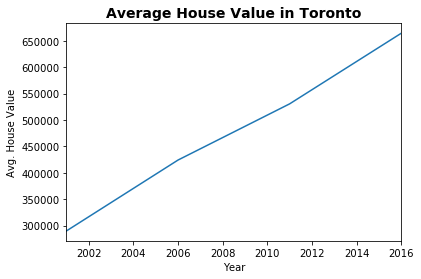

In [89]:
average_house_value()

In [90]:
average_value_by_neighbourhood()

:DynamicMap   [neighbourhood]
   :Curve   [year]   (average_house_value)

In [91]:
number_dwelling_types()

:DynamicMap   [neighbourhood]
   :Bars   [year,Variable]   (value)

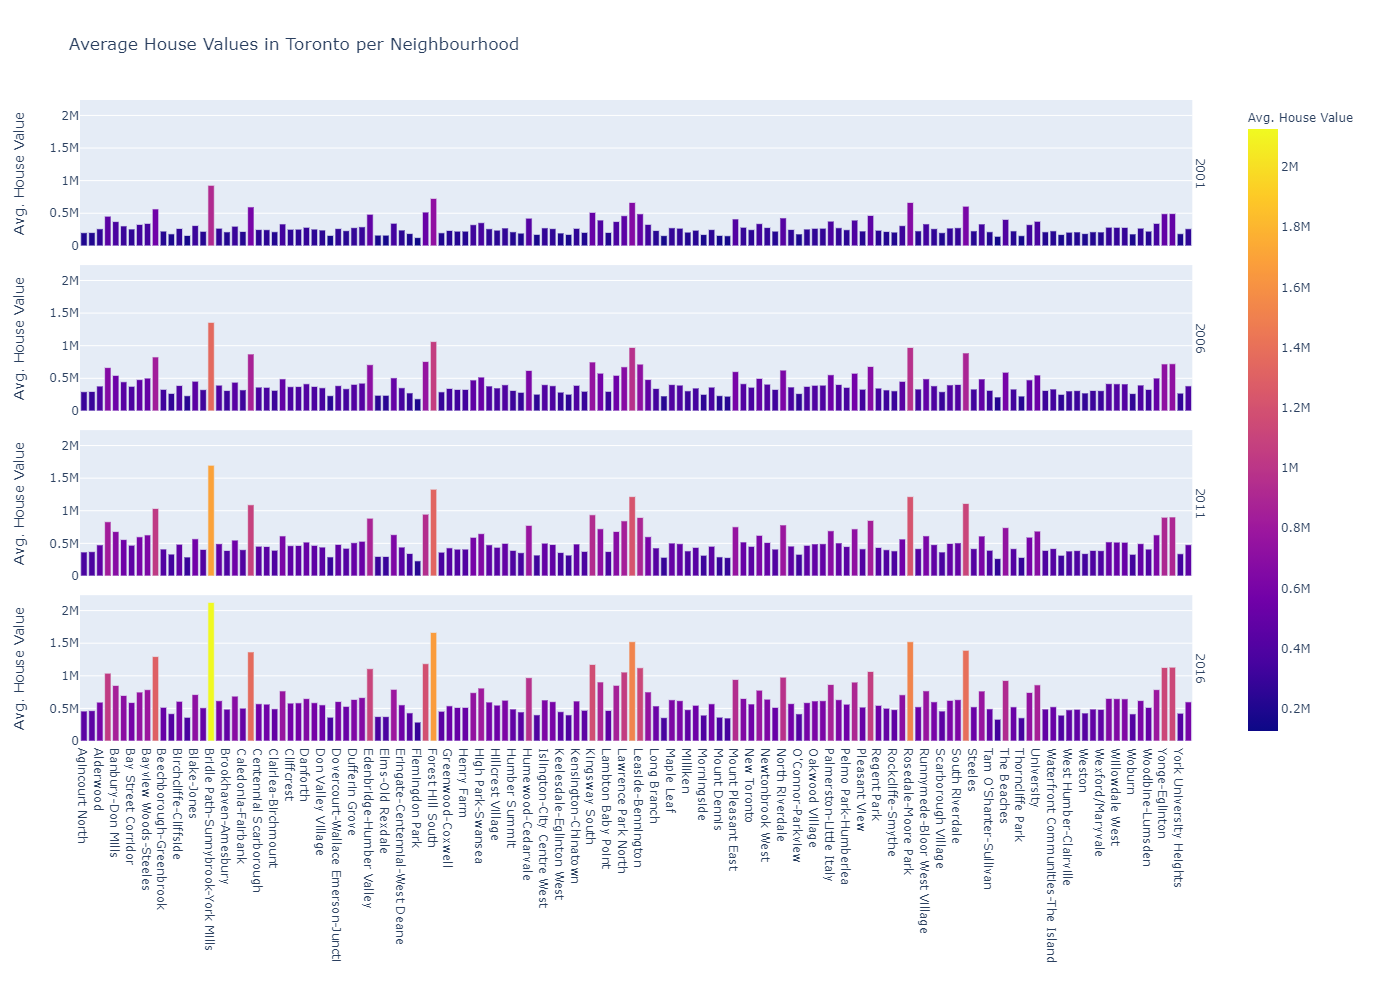

In [92]:
average_house_value_snapshot()

In [93]:
top_most_expensive_neighbourhoods()

:Bars   [neighbourhood]   (average_house_value)

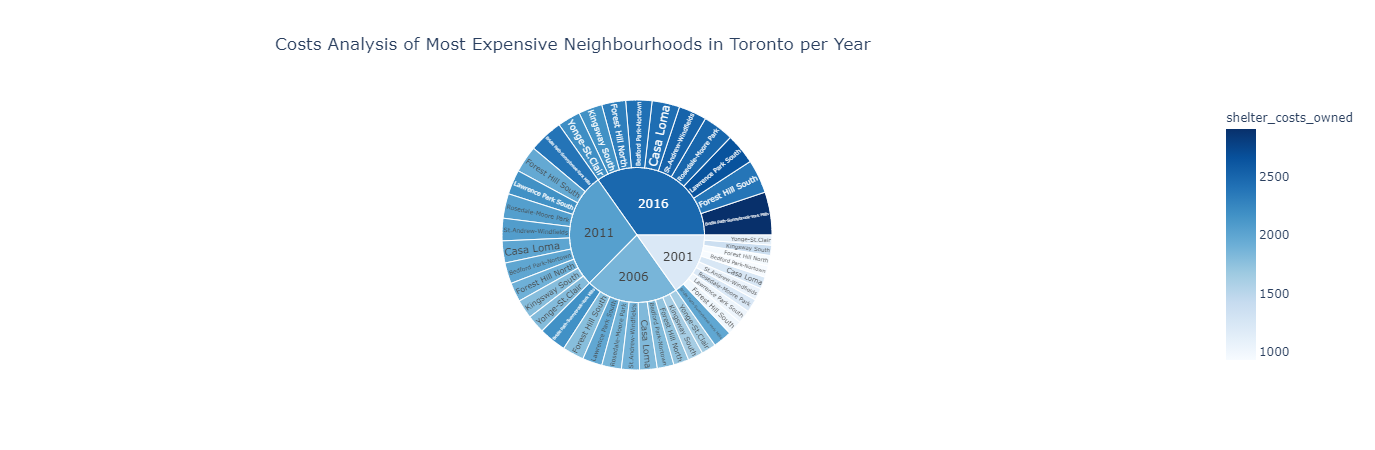

In [94]:
sunburts_cost_analysis()